In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
from itertools import chain

plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_pn_4GeV_Jul21_ntuple/*.root")




In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}

hists["hist_pdgid1"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )
hists["hist_pdgid2"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )
hists["hist_ke1"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 50, 4, 3500),
                                )
hists["hist_ke2"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 50, 4, 3500),
                                )


hists["mom_pdgid"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )
hists["mom_ke"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Energy [MeV]", 50, 4, 3500),
                                )




In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_n = ldmx_events['n']['Sim_PNParticle']
    sim_particle_dau1 = ldmx_events['Sim_PNParticle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_PNParticle_dau2']
    
    masks_id = {'Kplus': 321,
                'Kshort': 310,
                'Klong': 130, 
                'Kminus':-321,
                'Electron': 11,
                'Positron': -11,
                'Pion': 211,
                'Pi-': -211,
                'Proton':2212,
                'Neutron':2112,
                'Sigma': 3212,
                'Lambda': 3122,
               }
    masses =   {'Kplus': 493.677,
                'Kshort': 493.677,
                'Klong': 493.677,
                'Kminus': 493.677,
                'Electron': 0.511,
                'Positron': 0.511,
                'Pion': 139.57039,
                'Pi-': 139.57039,
                'Proton': 939.565,
                'Neutron': 939.565,
                'Sigma': 1189.36,
                'Lambda': 1115.6,
                }
    decay_num_mask1 = sim_particle_dau1.momdecay == 2
    decay_mom_mask1 = sim_particle_dau1.mompdgID == 310
    decay_mask1 = decay_num_mask1 & decay_mom_mask1
    
    decay_num_mask2 = sim_particle_dau2.momdecay == 2
    decay_mom_mask2 = sim_particle_dau2.mompdgID == 310
    decay_mask2 = decay_num_mask2 & decay_mom_mask2
    
    #print(sim_particle_dau1.pdgID)
    print(sim_particle_dau1[decay_mask1].pdgID)
    print(sim_particle_dau2[decay_mask2].pdgID)
     
    for part,pmask in masks_id.items():
        part_mask1 = (sim_particle_dau1[decay_mask1].pdgID == pmask)
        hists["hist_pdgid1"].fill(Ptype= part,
                                     e=flat(sim_particle_dau1[decay_mask1].pdgID[part_mask1]),
                                     )  
        hists["hist_ke1"].fill(Ptype= part,
                                     e=flat(sim_particle_dau1[decay_mask1].e[part_mask1])-masses[part],
                                     ) 
        part_mask2 = (sim_particle_dau2[decay_mask2].pdgID == pmask)
        hists["hist_pdgid2"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay_mask2].pdgID[part_mask2]),
                                     )  
        hists["hist_ke2"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay_mask2].e[part_mask2])-masses[part],
                                     ) 
        mom_part_mask = (sim_particle_dau1[decay_mask1].mompdgID == pmask)
        hists["mom_pdgid"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay_mask2].mompdgID[mom_part_mask]),
                                     )  
        hists["mom_ke"].fill(Ptype= part,
                                     e=flat(sim_particle_dau2[decay_mask2].mome[mom_part_mask])-masses[part],
                                     ) 


In [6]:
nchunk = 0
for chunk in ldmx_dict:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)
    

process 1
[[], [211], [], [211], [211], [], [], ... 211, 211], [], [], [], [211], [211], []]
[[], [-211], [], [-211], [-211], [], [], ... -211], [], [], [], [-211], [-211], []]
process 2
[[], [], [], [], [], [], [], [211], [211], ... [211], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [-211], ... -211], [], [], [], [], [], [], [], []]
process 3
[[], [], [], [], [], [], [211], [211], ... [], [], [], [], [], [211], [], [], []]
[[], [], [], [], [], [], [-211], [-211], ... [], [], [], [], [-211], [], [], []]
process 4
[[], [], [], [], [], [], [], [], [], [], ... [211], [], [], [211], [], [211], [], []]
[[], [], [], [], [], [], [], [], [], ... -211], [], [], [-211], [], [-211], [], []]
process 5
[[211], [211, 211], [], [], [211], [], [], ... [], [], [], [], [], [], [], [], []]
[[-211], [-211, -211], [], [], [-211], [], [], ... [], [], [], [], [], [], [], []]
process 6
[[], [], [], [], [211], [], [], [], [], ... [], [], [], [], [], [], [], [211], []]
[[], [], [], [], [-211], 

process 48
[[], [], [], [], [], [], [], [], [], [], ... [], [211], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], [], ... [], [-211], [], [], [], [], [], [], []]
process 49
[[], [], [], [], [], [], [], [], [211], ... [], [], [], [], [], [], [211], [], []]
[[], [], [], [], [], [], [], [], [-211], ... [], [], [], [], [], [], [-211], [], []]
process 50
[[211], [], [], [], [], [], [], [], [], ... 211], [], [211], [211], [211], [211], []]
[[-211], [], [], [], [], [], [], [], ... [], [-211], [-211], [-211], [-211], []]
process 51
[[211], [], [], [], [], [], [211], [], ... 211], [], [], [211], [], [211], [], []]
[[-211], [], [], [], [], [], [-211], [], ... [], [], [-211], [], [-211], [], []]
process 52
[[211], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]
[[-211], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]
process 53
[[], [211], [], [], [], [211], [], [], ... [], [211], [], [211], [], [211], []]
[[], [-211], [], [], [], 

process 95
[[], [], [], [], [], [], [211], [], [], ... [], [], [211], [], [], [], [], [], []]
[[], [], [], [], [], [], [-211], [], [], ... [], [], [-211], [], [], [], [], [], []]
process 96
[[], [], [211], [], [], [], [], [], [], ... [211], [], [], [], [], [211], [], []]
[[], [], [-211], [], [], [], [], [], [], ... [-211], [], [], [], [], [-211], [], []]
process 97
[[], [211], [], [], [], [], [], [211], [], ... [], [], [211], [], [], [], [], [], []]
[[], [-211], [], [], [], [], [], [-211], ... [], [-211], [], [], [], [], [], []]
process 98
[[], [211], [], [211], [], [211], [], ... [], [211], [211], [211, 211], [], [211]]
[[], [-211], [], [-211], [], [-211], ... [-211], [-211], [-211, -211], [], [-211]]
process 99
[[], [], [], [211], [], [], [], [], [], ... [211], [], [], [], [], [], [211], []]
[[], [], [], [-211], [], [], [], [], [], ... [-211], [], [], [], [], [], [-211], []]
process 100
[[], [], [], [], [], [211], [], [], [], ... [], [211], [], [211], [], [], [], []]
[[], [], [], [],

process 142
[[], [], [211], [], [], [], [], [], [], ... [], [211], [], [], [211], [211], [], []]
[[], [], [-211], [], [], [], [], [], ... [-211], [], [], [-211], [-211], [], []]
process 143
[[], [], [], [211], [], [], [], [], [], ... [], [], [], [], [], [211], [], [], []]
[[], [], [], [-211], [], [], [], [], [], ... [], [], [], [], [], [-211], [], [], []]
process 144
[[], [], [], [211], [211], [], [], [], [], ... [211], [], [], [], [], [], [], [], []]
[[], [], [], [-211], [-211], [], [], [], ... -211], [], [], [], [], [], [], [], []]
process 145
[[], [], [], [], [], [], [], [], [], ... [], [], [], [211], [], [211], [], [211]]
[[], [], [], [], [], [], [], [], [], ... [], [], [-211], [], [-211], [], [-211]]
process 146
[[], [], [211], [211], [], [211], [], [], ... [211], [], [], [], [], [], [], []]
[[], [], [-211], [-211], [], [-211], [], ... [-211], [], [], [], [], [], [], []]
process 147
[[], [211], [], [], [], [211], [211], [], ... [211], [], [], [], [], [], [], [], []]
[[], [-211], [

process 189
[[], [211], [], [], [], [211], [], [], ... [], [], [], [], [], [211], [211, 211]]
[[], [-211], [], [], [], [-211], [], ... [], [], [], [], [], [-211], [-211, -211]]
process 190
[[], [], [], [], [211], [], [], [], [], ... [], [], [211], [], [211], [211], [], []]
[[], [], [], [], [-211], [], [], [], ... [], [-211], [], [-211], [-211], [], []]
process 191
[[], [], [], [], [211], [], [], [], [], ... [211], [211], [], [], [], [], [], []]
[[], [], [], [], [-211], [], [], [], [], ... [-211], [-211], [], [], [], [], [], []]
process 192
[[], [], [], [], [], [], [], [], [], ... [], [211], [], [], [211], [], [211]]
[[], [], [], [], [], [], [], [], [], ... [], [-211], [], [], [-211], [], [-211]]
process 193
[[], [], [], [], [], [211], [], [211, 211], ... [], [], [], [211], [], [], [], []]
[[], [], [], [], [], [-211], [], [-211, -211, ... [], [], [], [-211], [], [], [], []]
process 194
[[211], [211], [], [], [211], [], [], [], ... [], [], [], [], [211, 211], [], [], []]
[[-211], [-211],

process 236
[[211], [], [], [], [], [], [], [], [211, ... [211], [], [], [211], [211], [], []]
[[-211], [], [], [], [], [], [], [], ... [-211], [], [], [-211], [-211], [], []]
process 237
[[], [], [], [], [], [], [], [], [], [], ... [211], [], [211], [211], [], [], [], []]
[[], [], [], [], [], [], [], [], [], ... -211], [], [-211], [-211], [], [], [], []]
process 238
[[], [211], [], [], [211], [211], [], [], ... [], [], [], [], [211], [], [], [], []]
[[], [-211], [], [], [-211], [-211], [], ... [], [], [], [-211], [], [], [], []]
process 239
[[], [211], [211], [], [211], [211], [211], ... [], [], [211], [], [], [], [], []]
[[], [-211], [-211], [], [-211], [-211], ... [], [], [-211], [], [], [], [], []]
process 240
[[], [211], [], [], [211], [], [211], [], ... [211], [], [], [211], [], [], [], []]
[[], [-211], [], [], [-211], [], [-211], ... -211], [], [], [-211], [], [], [], []]
process 241
[[], [], [], [211], [], [211], [], [], [], ... [], [], [], [], [], [211], [], [], []]
[[], [], [

process 283
[[], [], [], [], [], [], [], [], [211], ... [], [], [211], [211], [], [], [211], []]
[[], [], [], [], [], [], [], [], [-211, ... [], [-211], [-211], [], [], [-211], []]
process 284
[[], [], [211], [211], [211, 211], [], [211, ... [], [], [211], [], [], [], [], []]
[[], [], [-211], [-211], [-211, -211], [], ... [], [], [-211], [], [], [], [], []]
process 285
[[], [], [], [], [], [], [], [211, 211], ... [], [], [], [], [], [211], [], []]
[[], [], [], [], [], [], [], [-211, -211], ... [], [], [], [], [], [-211], [], []]
process 286
[[], [], [], [211], [211], [], [211], [], ... [], [], [211], [], [211], [], [], []]
[[], [], [], [-211], [-211], [], [-211], ... [], [-211], [], [-211], [], [], []]
process 287
[[], [], [], [], [], [], [], [], [], ... [], [211], [], [211, 211], [], [211], []]
[[], [], [], [], [], [], [], [], [], ... [-211], [], [-211, -211], [], [-211], []]
process 288
[[], [], [211], [211], [], [], [], [], ... [], [], [], [211], [], [], [], []]
[[], [], [-211], [-2

process 330
[[], [211], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]
[[], [-211], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], []]
process 331
[[], [], [], [211], [], [], [], [], [], ... [211], [], [], [], [211], [], [211], []]
[[], [], [], [-211], [], [], [], [], ... [], [], [], [-211], [], [-211], []]
process 332
[[], [], [], [], [211], [], [], [], [211, ... [], [], [211], [], [211], [211], []]
[[], [], [], [], [-211], [], [], [], ... [], [], [-211], [], [-211], [-211], []]
process 333
[[], [211], [], [], [], [211, 211], [], ... [211], [], [], [], [211], [], []]
[[], [-211], [], [], [], [-211, -211], [], ... [-211], [], [], [], [-211], [], []]
process 334
[[], [211], [], [], [], [], [211], [], ... [], [], [211], [], [], [], [], [], []]
[[], [-211], [], [], [], [], [-211], [], ... [], [-211], [], [], [], [], [], []]
process 335
[[211], [211], [], [], [], [], [], [], [], ... [], [], [], [], [], [211], [], [], []]
[[-211], [-211], [], [], [], []

<Hist (Ptype,e) instance at 0x12e553f40>


/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


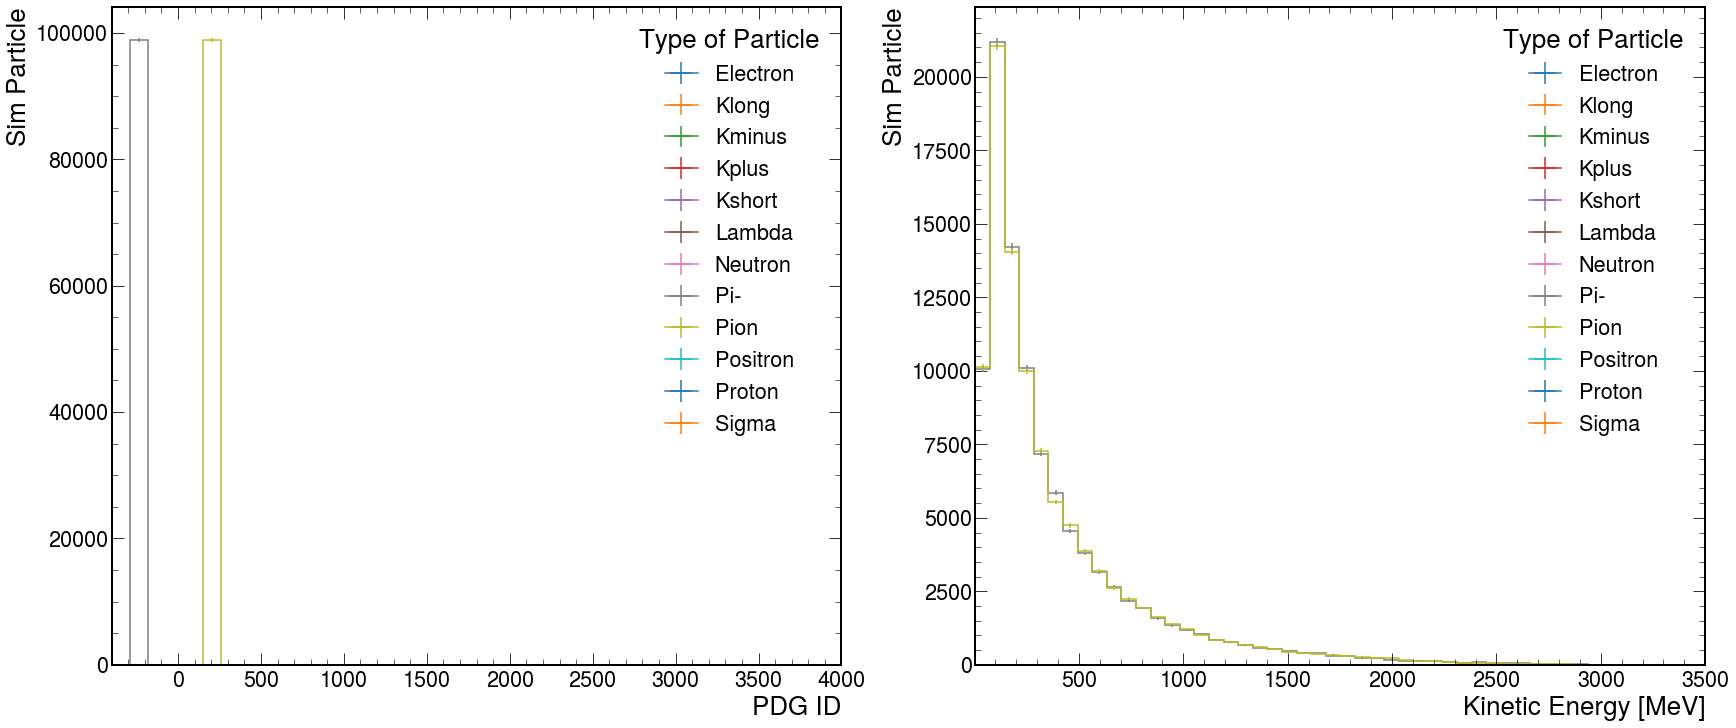

In [7]:
print(hists["hist_pdgid1"])
fig, ax = plt.subplots(1,2, figsize=(24,10), constrained_layout=True)
hist.plot1d(hists["hist_pdgid1"]+hists["hist_pdgid2"],ax=ax[0],clear=False);
#leg = ax[0].legend([r'$K_S$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$',r'$\Sigma$'])

hist.plot1d(hists["hist_ke1"]+hists["hist_ke2"],ax=ax[1],clear=False);
#leg = ax[1].legend([r'$K_S$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$',r'$\Sigma$'])



<Hist (Ptype,e) instance at 0x12e4e2160>


/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


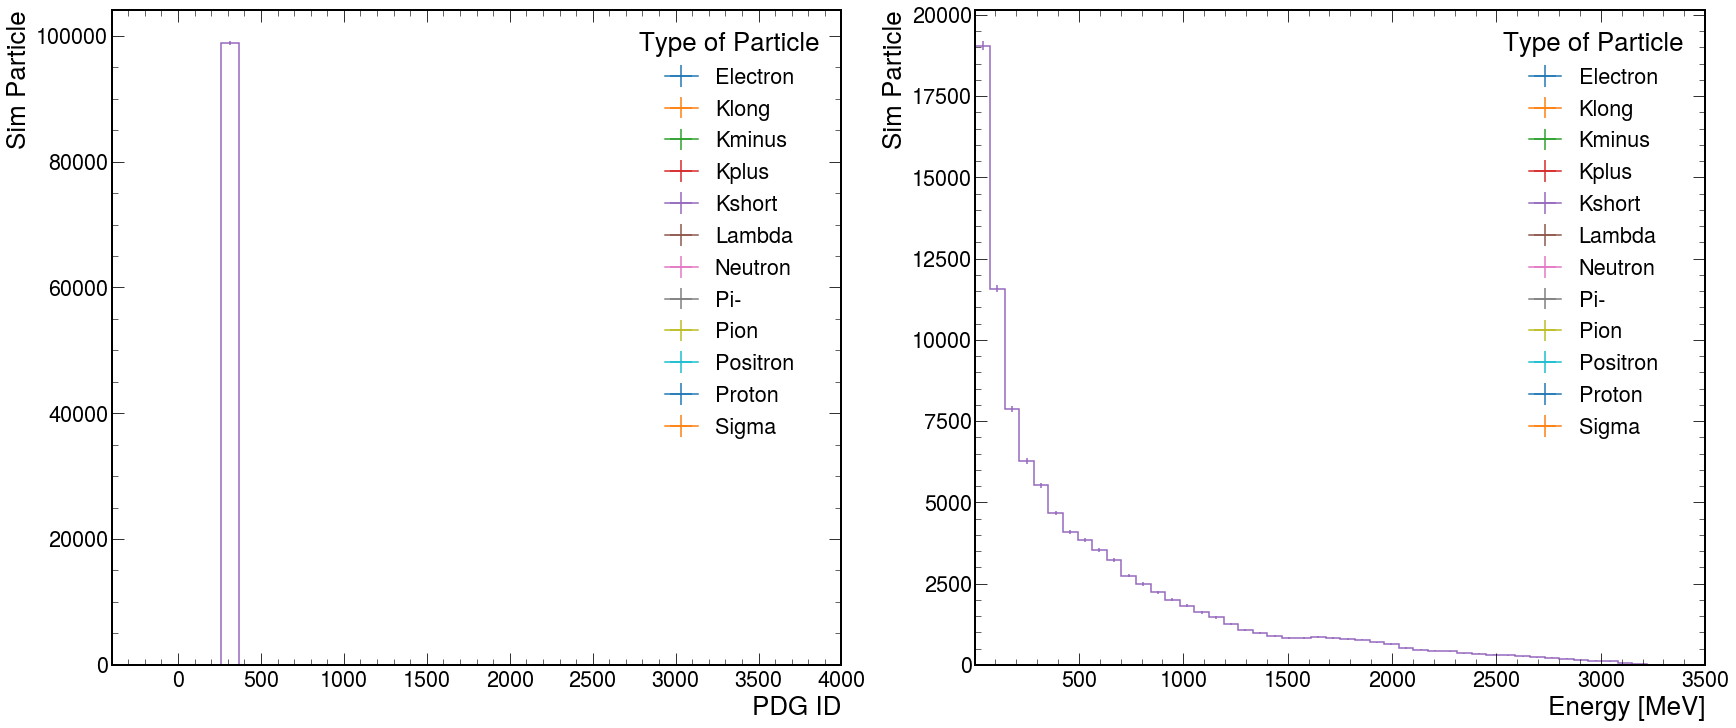

In [11]:
print(hists["mom_pdgid"])
fig, ax = plt.subplots(1,2, figsize=(24,10), constrained_layout=True)
hist.plot1d(hists["mom_pdgid"],ax=ax[0],clear=False);
#leg = ax[0].legend([r'$K_S$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$',r'$\Sigma$'])

hist.plot1d(hists["mom_ke"],ax=ax[1],clear=False);
#leg = ax[1].legend([r'$K_S$'])

